In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '/home/sdybing/gnss-picker/cnn_models_outputs/newfault_fq_train/models/traindate_2024-10-01/data/'

In [3]:
# data = np.load(path + '2024-10-15_gfast_fqtest_orig_data.npy')
# metadata = np.load(path + 'pgd_test_metadata_with_hypdists.npy')

data = np.load(path + '2024-10-17_gfast_alltestdata_fqtest_orig_data.npy')
metadata = np.load(path + 'pgd_alltestdata_test_metadata_w_hypdist_pgd_snrs.npy')

# np.save(data_save_dir + str(fqtestdate) + '_gfast_fqtest_target.npy', fqtest_target)
# np.save(data_save_dir + str(fqtestdate) + '_gfast_fqtest_predictions.npy', fqtest_predictions)

# Columns:

# 0: FQ rupture name
# 1: station name
# 2: magnitude
# 3: P-arrival index
# 4: FQ rupture hypocenter lat
# 5: FQ rupture hypocenter lon
# 6: FQ rupture hypocenter depth (km)
# 7: station lat
# 8: station lon
# 9: hypocentral distance (m)
# 10. PGD (m)
# 11. SNRN
# 12. SNRE
# 13. SNRZ
# 14. mean SNR

In [4]:
all_true_mws = metadata[:,2].astype(float)

In [5]:
all_true_mws

array([4.2716, 7.2549, 6.749 , ..., 5.1814, 5.8157, 4.8519])

In [6]:
# Crowell 2016 used PGD in cm, Rhyp in km 
# log10(PGD) = A + B*Mw + C*Mw*log10(Rhyp)
A = -6.687
B = 1.5
C = -0.214

pgd_ts_array = np.zeros((len(data), 128))
Mw_ts_array = np.zeros((len(data), 128))

for idx in range(len(data)):
    
    n = data[idx, :, 0]*100 # converting disp from m to cm
    e = data[idx, :, 1]*100
    z = data[idx, :, 2]*100
    
    Rhyp = float(metadata[idx,9])/1000
    actual_Mw = float(metadata[idx,2])
#     print(Rhyp)
    
#     plt.plot(n)
#     plt.plot(e)
#     plt.plot(z)
    
    pgd_ts = np.sqrt(n**2 + e**2 + z**2)
#     plt.plot(pgd_ts)
#     plt.show()
    
    Mw_ts = (np.log10(pgd_ts) - A) / (B + C * np.log10(Rhyp))
    
#     plt.plot(Mw_ts)
#     plt.show()
    
    pgd_ts_array[idx] = pgd_ts
    Mw_ts_array[idx] = Mw_ts
    
#     print(actual_Mw, np.max(Mw_ts))

In [7]:
all_calc_mws = []

for k in range(len(Mw_ts_array)):
    
    calc_Mw = np.max(Mw_ts_array[k])
    all_calc_mws.append(calc_Mw)
    
all_calc_mws = np.array(all_calc_mws)

In [8]:
all_calc_mws

array([7.47928835, 7.36484815, 7.73931332, ..., 7.20483974, 7.04581028,
       6.95392184])

In [9]:
# Get residuals

all_resids = []

for i in range(len(all_true_mws)):
    
    true_mw = all_true_mws[i]
    calc_mw = all_calc_mws[i]
    
    resid = true_mw - calc_mw
    all_resids.append(resid)
    
all_resids = np.array(all_resids)

In [10]:
all_resids

array([-3.20768835, -0.10994815, -0.99031332, ..., -2.02343974,
       -1.23011028, -2.10202184])

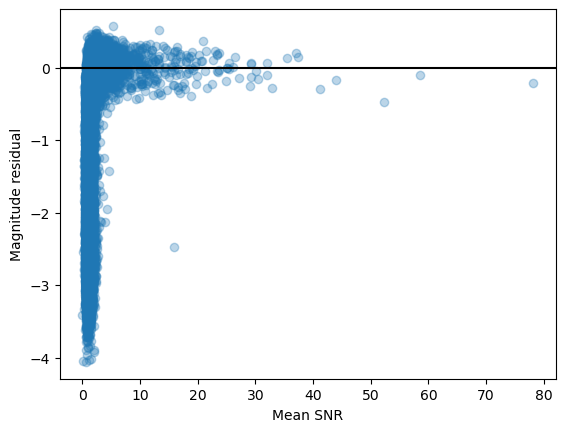

In [11]:
mean_SNRs = metadata[:,14].astype(float)

plt.scatter(mean_SNRs, all_resids, alpha = 0.3)
plt.axhline(y = 0, color = 'black')
plt.xlabel('Mean SNR')
plt.ylabel('Magnitude residual')

plt.show();

## Filter by SNR

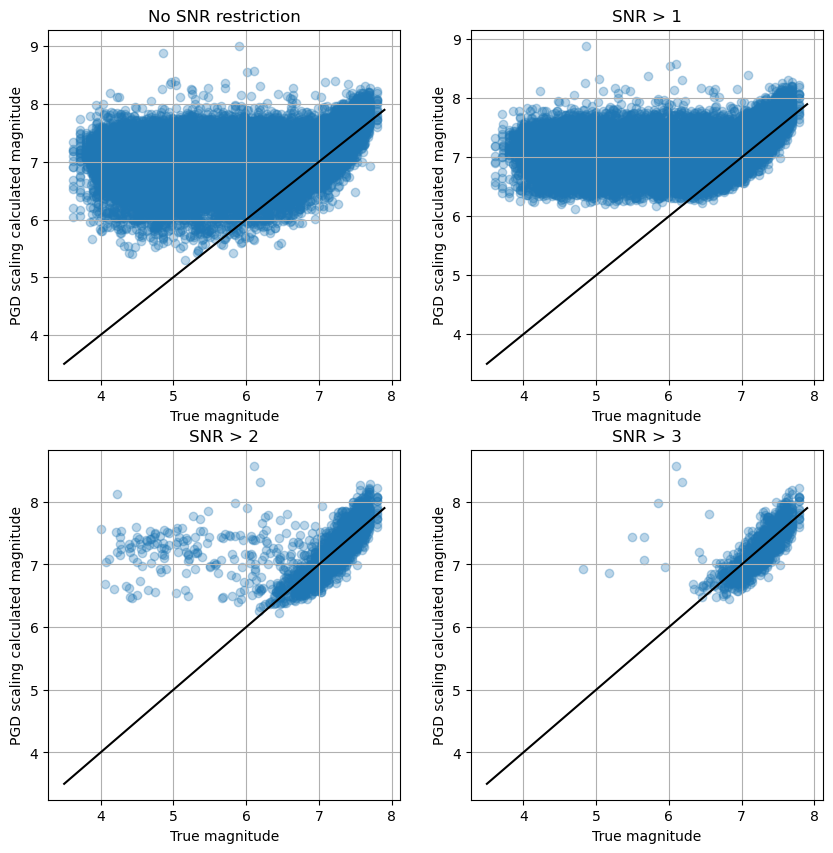

In [12]:
# Restricting plot by SNR

plt.figure(figsize = (10,10), dpi = 100)

x = np.arange(3.5,8,0.1)

plt.subplot(221)
all_true_mws = metadata[:,2].astype(float)
plt.grid()
plt.scatter(all_true_mws, all_calc_mws, alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('No SNR restriction')

plt.subplot(222)
k = np.where(mean_SNRs > 1)[0]
resids_SNR2 = np.array(all_resids)[k]
plt.grid()
plt.scatter(all_true_mws[k], np.array(all_calc_mws)[k], alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 1')

plt.subplot(223)
k = np.where(mean_SNRs > 2)[0]
resids_SNR2 = np.array(all_resids)[k]
plt.grid()
plt.scatter(all_true_mws[k], np.array(all_calc_mws)[k], alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 2')

plt.subplot(224)
k = np.where(mean_SNRs > 3)[0]
resids_SNR2 = np.array(all_resids)[k]
plt.grid()
plt.scatter(all_true_mws[k], np.array(all_calc_mws)[k], alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 3')

plt.show();

### SNR filter event-average PGD magnitude

In [13]:
uni_rupts = np.unique(metadata[:,0])
print(uni_rupts)

['newfault.000000' 'newfault.000001' 'newfault.000002' ...
 'newfault.003297' 'newfault.003298' 'newfault.003299']


In [14]:
true_mws = []
calc_mws_none = []
calc_mws_1 = []
calc_mws_2 = []
calc_mws_3 = []

for idx2 in range(len(uni_rupts)):
    
    rupt = uni_rupts[idx2]
#     print(rupt)
    
    i = np.where(metadata[:,0] == rupt)[0]
#     print(metadata[i])
    
    mws_none = []
    mws_1 = []
    mws_2 = []
    mws_3 = []
    for index in i:
        computed_mw = np.max(Mw_ts_array[index])
        mws_none.append(computed_mw)
        SNR = float(metadata[index,14])
#         print('SNR: ' + str(SNR))
        if SNR > 1:
#             print(computed_mw)
            mws_1.append(computed_mw)
        if SNR > 2:
#             print(computed_mw)
            mws_2.append(computed_mw)
        if SNR > 3:
#             print(computed_mw)
            mws_3.append(computed_mw)
    
#     print(mws_3)
    
    try:
        evt_avg_mean_Mw_none = np.mean(np.array(mws_none))
    except: 
        evt_avg_mean_Mw_none = np.nan
    try:
        evt_avg_mean_Mw_1 = np.mean(np.array(mws_1))
    except: 
        evt_avg_mean_Mw_1 = np.nan
    try:
        evt_avg_mean_Mw_2 = np.mean(np.array(mws_2))
    except: 
        evt_avg_mean_Mw_2 = np.nan
    try:
        evt_avg_mean_Mw_3 = np.mean(np.array(mws_3))
    except: 
        evt_avg_mean_Mw_3 = np.nan
    
    true_Mw = float(metadata[i,2][0])
#     print(metadata[i,2][0])

    true_mws.append(true_Mw)
    calc_mws_none.append(evt_avg_mean_Mw_none)
    calc_mws_1.append(evt_avg_mean_Mw_1)
    calc_mws_2.append(evt_avg_mean_Mw_2)
    calc_mws_3.append(evt_avg_mean_Mw_3)
    
#     print(true_Mw)
#     print(evt_avg_mean_Mw)


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


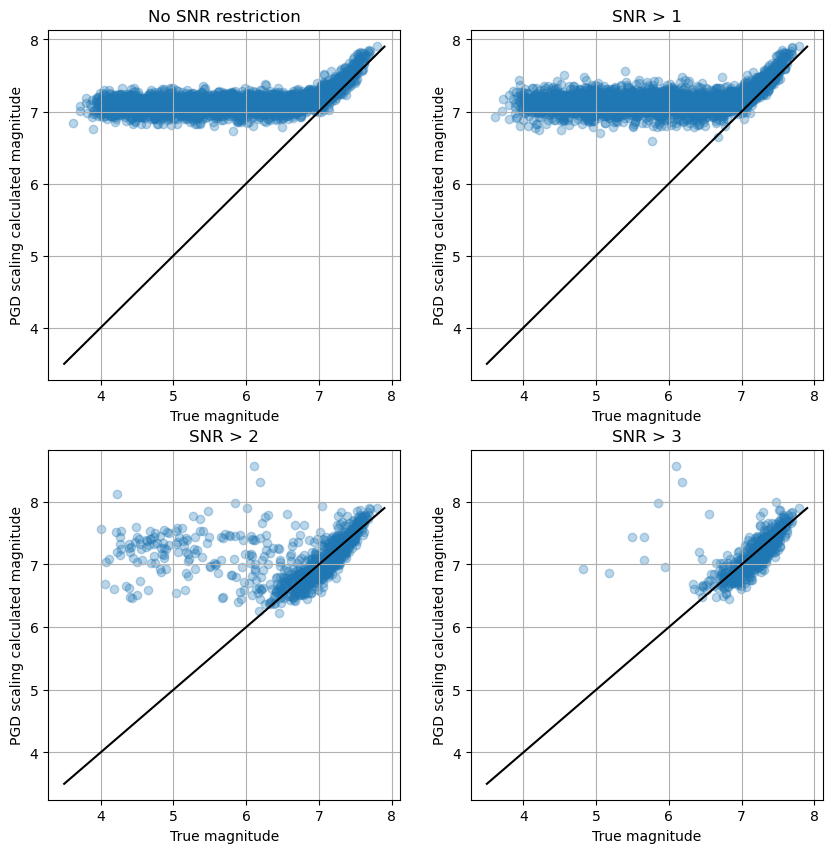

In [15]:
# Restricting event-average plot by SNR

plt.figure(figsize = (10,10), dpi = 100)

x = np.arange(3.5,8,0.1)

plt.subplot(221)
plt.grid()
plt.scatter(true_mws, calc_mws_none, alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('No SNR restriction')

plt.subplot(222)
plt.grid()
plt.scatter(true_mws, calc_mws_1, alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 1')

plt.subplot(223)
plt.grid()
plt.scatter(true_mws, calc_mws_2, alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 2')

plt.subplot(224)
plt.grid()
plt.scatter(true_mws, calc_mws_3, alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('SNR > 3')

plt.show();

## Hypocentral distance filter



In [16]:
true_mws = []
calc_mws_all = []
calc_mws_25 = []
calc_mws_50 = []
calc_mws_100 = []
calc_mws_200 = []

for idx in range(len(uni_rupts)):
    
    rupt = uni_rupts[idx]
#     print(rupt)
    
    i = np.where(metadata[:,0] == rupt)[0]
#     print(metadata[i])
    
    mws_all = []
    mws_25 = []
    mws_50 = []
    mws_100 = []
    mws_200 = []

    for index in i:
        computed_mw = np.max(Mw_ts_array[index])
        mws_all.append(computed_mw)
        
        hypdist = float(metadata[index,9])/1000 # km
        if hypdist <= 25:
            mws_25.append(computed_mw)
        if hypdist <= 50:
            mws_50.append(computed_mw)
        if hypdist <= 100:
            mws_100.append(computed_mw)
        if hypdist <= 200:
            mws_200.append(computed_mw)
    
    try:
        evt_avg_mean_Mw_all = np.mean(np.array(mws_all))
    except: 
        evt_avg_mean_Mw_all = np.nan
    try:
        evt_avg_mean_Mw_25 = np.mean(np.array(mws_25))
    except: 
        evt_avg_mean_Mw_25 = np.nan
    try:
        evt_avg_mean_Mw_50 = np.mean(np.array(mws_50))
    except: 
        evt_avg_mean_Mw_50 = np.nan
    try:
        evt_avg_mean_Mw_100 = np.mean(np.array(mws_100))
    except: 
        evt_avg_mean_Mw_100 = np.nan
    try:
        evt_avg_mean_Mw_200 = np.mean(np.array(mws_200))
    except: 
        evt_avg_mean_Mw_200 = np.nan
    
    true_Mw = float(metadata[i,2][0])
    
    true_mws.append(true_Mw)
    calc_mws_all.append(evt_avg_mean_Mw_all)
    calc_mws_25.append(evt_avg_mean_Mw_25)
    calc_mws_50.append(evt_avg_mean_Mw_50)
    calc_mws_100.append(evt_avg_mean_Mw_100)
    calc_mws_200.append(evt_avg_mean_Mw_200)
    
#     print(true_Mw)
#     print(evt_avg_mean_Mw)


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


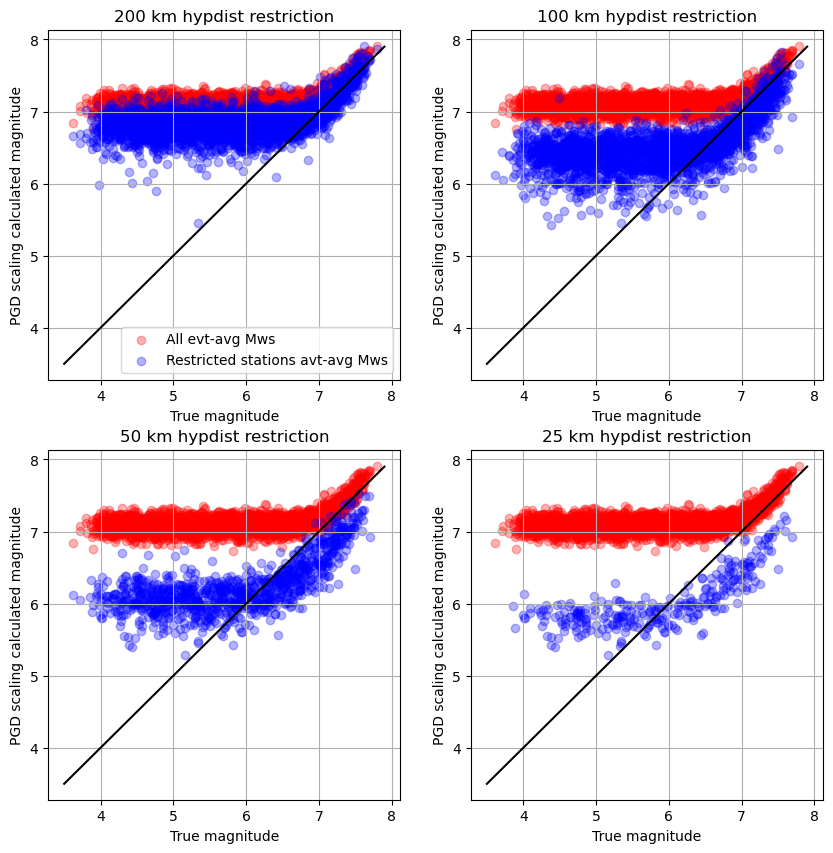

In [17]:
# Restricting event-average plot by hypdist

plt.figure(figsize = (10,10), dpi = 100)

x = np.arange(3.5,8,0.1)

plt.subplot(221)
plt.grid()
plt.scatter(true_mws, calc_mws_all, color = 'red', alpha = 0.3, label = 'All evt-avg Mws')
plt.scatter(true_mws, calc_mws_200, color = 'blue', alpha = 0.3, label = 'Restricted stations avt-avg Mws')
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('200 km hypdist restriction')
plt.legend()

plt.subplot(222)
plt.grid()
plt.scatter(true_mws, calc_mws_all, color = 'red', alpha = 0.3)
plt.scatter(true_mws, calc_mws_100, color = 'blue', alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('100 km hypdist restriction')

plt.subplot(223)
plt.grid()
plt.scatter(true_mws, calc_mws_all, color = 'red', alpha = 0.3)
plt.scatter(true_mws, calc_mws_50, color = 'blue', alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('50 km hypdist restriction')

plt.subplot(224)
plt.grid()
plt.scatter(true_mws, calc_mws_all, color = 'red', alpha = 0.3)
plt.scatter(true_mws, calc_mws_25, color = 'blue', alpha = 0.3)
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.title('25 km hypdist restriction')

plt.show();

## Hypocentral distance weighting + 4 stations min to contribute (GFAST proxy)

In [18]:
true_mws = []
calc_mws_all = []
calc_mws_weighted = []

for idx in range(len(uni_rupts)):
    
    rupt = uni_rupts[idx]
#     print(rupt)
    
    i = np.where(metadata[:,0] == rupt)[0]
#     print(metadata[i])
    true_Mw = float(metadata[i,2][0])
    true_mws.append(true_Mw)
#     print('True: ' + str(round(true_Mw,2)))
    
    hypdists = metadata[i,9].astype(float)/1000
    computed_mws = np.max(Mw_ts_array[i], axis = 1)
    
#     print(hypdists.shape)
#     print(computed_mws.shape)
#     print(min(hypdists))
    
    evt_avg_mean_Mw_all = np.mean(computed_mws)
    calc_mws_all.append(evt_avg_mean_Mw_all)
#     print('Basic mean: ' + str(round(evt_avg_mean_Mw_all,2)))
    
    if len(computed_mws) < 4:
        weighted_evt_avg_Mw = np.nan
        calc_mws_weighted.append(weighted_evt_avg_Mw)
        continue
    
    weights = np.exp(-(hypdists**2) / (8 * (min(hypdists)**2)))
#     print(weights.shape)
    
    weighted_evt_avg_Mw = np.average(computed_mws, weights = weights)
    calc_mws_weighted.append(weighted_evt_avg_Mw)
#     print('Weighted mean: ' + str(round(weighted_evt_avg_Mw,2)))

print(len(true_mws))
print(len(calc_mws_all))
print(len(calc_mws_weighted))

3300
3300
3300


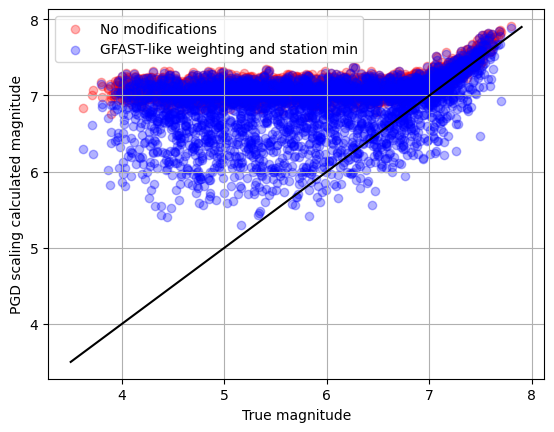

In [19]:
x = np.arange(3.5,8,0.1)
plt.grid()
plt.scatter(true_mws, calc_mws_all, color = 'red', alpha = 0.3, label = 'No modifications')
plt.scatter(true_mws, calc_mws_weighted, color = 'blue', alpha = 0.3, label = 'GFAST-like weighting and station min')
plt.plot(x, x, color = 'black')
plt.xlabel('True magnitude')
plt.ylabel('PGD scaling calculated magnitude')
plt.legend()

plt.show();

In [21]:
# Only works after running code 7
all_calc_mws = []

for k in range(len(Mw_ts_array)):
    
    calc_Mw = np.max(Mw_ts_array[k])
    all_calc_mws.append(calc_Mw)
    
results0135 = np.load(path + 'pgd_alltestdata_test_metadata_w_hypdist_pgd_snrs_result0135.npy') # Best accuracy threshold from FQ testing data
results0835 = np.load(path + 'pgd_alltestdata_test_metadata_w_hypdist_pgd_snrs_result0835.npy') # Best precision threshold from FQ testing data
results0135.shape

(45870, 16)

In [22]:
# p = np.where(results[:,15] == 'false neg')[0]
# print(len(p))
# q = np.where(results[:,15] == 'true pos')[0]
# print(len(q))

# all_true_mws = metadata[:,2].astype(float)
# all_calc_mws = np.array(all_calc_mws)

# fn_all_true_mws = all_true_mws[p]
# fn_all_calc_mws = all_calc_mws[p]
# tp_all_true_mws = all_true_mws[q]
# tp_all_calc_mws = all_calc_mws[q]

# x = np.arange(3.5,8,0.1)
# plt.grid()
# plt.scatter(fn_all_true_mws, fn_all_calc_mws, color = 'red', alpha = 0.3, label = 'False negatives')
# plt.scatter(tp_all_true_mws, tp_all_calc_mws, color = 'blue', alpha = 0.3, label = 'True positives')
# plt.plot(x, x, color = 'black')
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')
# plt.legend()

# plt.show();

In [23]:
# mean_SNRs = results[:,14].astype(float)

# fn_mean_SNRs = mean_SNRs[p]
# tp_mean_SNRs = mean_SNRs[q]
# fn_all_resids = np.array(all_resids)[p]
# tp_all_resids = np.array(all_resids)[q]

# plt.scatter(fn_mean_SNRs, fn_all_resids, color = 'red', alpha = 0.3, label = 'False negatives')
# plt.scatter(tp_mean_SNRs, tp_all_resids, color = 'blue', alpha = 0.3, label = 'True positives')
# plt.axhline(y = 0, color = 'black')
# plt.xlabel('Mean SNR')
# plt.ylabel('Magnitude residual')
# plt.legend()

# plt.show();

In [24]:
true_mws_0135 = []
calc_mws_fn_0135 = []
calc_mws_tp_0135 = []
true_mws_0835 = []
calc_mws_fn_0835 = []
calc_mws_tp_0835 = []

for idx2 in range(len(uni_rupts)):
    
    rupt = uni_rupts[idx2]
#     print(rupt)
    
    i = np.where(results0135[:,0] == rupt)[0]
#     print(metadata[i])
    
    mws_tp_0135 = []
    mws_fn_0135 = []
    mws_tp_0835 = []
    mws_fn_0835 = []
    for index in i:
        computed_mw = np.max(Mw_ts_array[index])
        mws_none.append(computed_mw)
        result_0135 = results0135[index,15]
        result_0835 = results0835[index,15]
#         print('Result: ' + result)
        if result_0135 == 'true pos':
            mws_tp_0135.append(computed_mw)
        elif result_0135 == 'false neg':
            mws_fn_0135.append(computed_mw)
        
        if result_0835 == 'true pos':
            mws_tp_0835.append(computed_mw)
        elif result_0835 == 'false neg':
            mws_fn_0835.append(computed_mw)
    
    try:
        evt_avg_mean_Mw_tp_0135 = np.mean(np.array(mws_tp_0135))
    except:
        evt_avg_mean_Mw_tp_0135 = np.nan
    try:
        evt_avg_mean_Mw_fn_0135 = np.mean(np.array(mws_fn_0135))
    except:
        evt_avg_mean_Mw_fn_0135 = np.nan
    try:
        evt_avg_mean_Mw_tp_0835 = np.mean(np.array(mws_tp_0835))
    except:
        evt_avg_mean_Mw_tp_0835 = np.nan
    try:
        evt_avg_mean_Mw_fn_0835 = np.mean(np.array(mws_fn_0835))
    except:
        evt_avg_mean_Mw_fn_0835 = np.nan
    
    true_Mw = float(metadata[i,2][0])
    
    true_mws_0135.append(true_Mw)
    true_mws_0835.append(true_Mw)
    calc_mws_fn_0135.append(evt_avg_mean_Mw_fn_0135)
    calc_mws_tp_0135.append(evt_avg_mean_Mw_tp_0135)
    calc_mws_fn_0835.append(evt_avg_mean_Mw_fn_0835)
    calc_mws_tp_0835.append(evt_avg_mean_Mw_tp_0835)
    
#     print(true_Mw)
#     print(evt_avg_mean_Mw)


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
len(calc_mws_tp_0135)

3300

In [26]:
len(calc_mws_tp_0835)

3300

In [ ]:
# # Restricting event-average plot by TPs

# plt.figure(figsize = (10,5), dpi = 100)

# x = np.arange(3.5,8,0.1)

# plt.subplot(121)
# plt.grid()
# plt.scatter(true_mws, calc_mws_fn, color = 'red', alpha = 0.3)
# plt.plot(x, x, color = 'black')
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')
# plt.title('False negatives')

# plt.subplot(122)
# plt.grid()
# plt.scatter(true_mws, calc_mws_tp, color = 'blue', alpha = 0.3)
# plt.plot(x, x, color = 'black')
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')
# plt.title('True positives')

# plt.show();

In [ ]:
# # Restricting event-average plot by SNR

# plt.figure(figsize = (6,5), dpi = 100)

# x = np.arange(3.5,8,0.1)

# plt.grid()
# plt.scatter(true_mws, calc_mws_fn, color = 'red', alpha = 0.3)
# plt.scatter(true_mws, calc_mws_tp, color = 'blue', alpha = 0.3)
# plt.plot(x, x, color = 'black')
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')

# plt.show();

## Combining plots


In [27]:
true_event_mags = np.array(true_mws)
print(true_event_mags.shape)

calc_event_mags_nofilter = np.array(calc_mws_all)
print(calc_event_mags_nofilter.shape)

calc_event_mags_snr1 = np.array(calc_mws_1)
calc_event_mags_snr2 = np.array(calc_mws_2)
calc_event_mags_snr3 = np.array(calc_mws_3)

calc_event_mags_tps_0135 = np.array(calc_mws_tp_0135)
print(calc_event_mags_tps_0135.shape)
calc_event_mags_tps_0835 = np.array(calc_mws_tp_0835)
print(calc_event_mags_tps_0835.shape)

calc_event_mags_gfastweight = np.array(calc_mws_weighted)

(3300,)
(3300,)
(3300,)
(3300,)


In [28]:
# Calculating residuals and mean squared errors

all_residuals = true_event_mags - calc_event_mags_nofilter
snr1_residuals = true_event_mags - calc_event_mags_snr1
snr2_residuals = true_event_mags - calc_event_mags_snr2
snr3_residuals = true_event_mags - calc_event_mags_snr3
tp_0135_residuals = true_event_mags - calc_event_mags_tps_0135
tp_0835_residuals = true_event_mags - calc_event_mags_tps_0835
gfast_residuals = true_event_mags - calc_event_mags_gfastweight

# Remove nans from snr and tp ones to compute mse:

snr1_resids_nonan = []
for i in range(len(snr1_residuals)):
    resid = str(snr1_residuals[i])
    if resid != 'nan':
        snr1_resids_nonan.append(float(resid))
snr1_resids_nonan = np.array(snr1_resids_nonan)
# print(snr1_resids_nonan.shape)

snr2_resids_nonan = []
for i in range(len(snr2_residuals)):
    resid = str(snr2_residuals[i])
    if resid != 'nan':
        snr2_resids_nonan.append(float(resid))
snr2_resids_nonan = np.array(snr2_resids_nonan)
# print(snr2_resids_nonan.shape)

snr3_resids_nonan = []
for i in range(len(snr3_residuals)):
    resid = str(snr3_residuals[i])
    if resid != 'nan':
        snr3_resids_nonan.append(float(resid))
snr3_resids_nonan = np.array(snr3_resids_nonan)
# print(snr3_resids_nonan.shape)

tp_0135_resids_nonan = []
for i in range(len(tp_0135_residuals)):
    resid = str(tp_0135_residuals[i])
    if resid != 'nan':
        tp_0135_resids_nonan.append(float(resid))
tp_0135_resids_nonan = np.array(tp_0135_resids_nonan)
# print(tp_0135_resids_nonan.shape)

tp_0835_resids_nonan = []
for i in range(len(tp_0835_residuals)):
    resid = str(tp_0835_residuals[i])
    if resid != 'nan':
        tp_0835_resids_nonan.append(float(resid))
tp_0835_resids_nonan = np.array(tp_0835_resids_nonan)
# print(tp_0835_resids_nonan.shape)

all_mse = round(np.mean(all_residuals**2),3)
snr1_mse = round(np.mean(snr1_resids_nonan**2),3)
snr2_mse = round(np.mean(snr2_resids_nonan**2),3)
snr3_mse = round(np.mean(snr3_resids_nonan**2),3)
tp_0135_mse = round(np.mean(tp_0135_resids_nonan**2),3)
tp_0835_mse = round(np.mean(tp_0835_resids_nonan**2),3)
gfast_mse = round(np.mean(gfast_residuals**2),3)

print(all_mse)
print(snr1_mse)
print(snr2_mse)
print(snr3_mse)
print(tp_0135_mse)
print(tp_0835_mse)
print(gfast_mse)

2.557
2.625
0.803
0.097
2.249
0.045
1.938


In [30]:
# Event-averaged only

x = np.arange(3.5,8,0.1)

plt.figure(figsize = (10,13), dpi = 400)

plt.subplot(321)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(a)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_gfastweight, color = 'blue', alpha = 0.3, label = 'GFAST-like distance\nweighting and 4\nstation minimum')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'GFAST MSE: ' + str(gfast_mse) + '\nEvents qualified: ' + str(round(len(gfast_residuals)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
# plt.xlabel('True magnitude', fontsize = 12)
# plt.ylabel('PGD scaling calculated magnitude', fontsize = 12)
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('GFAST-like distance weighting and 4 station min')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', bottom = False, labelbottom = False, labelsize = 11)

plt.subplot(322)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(b)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_snr1, color = 'blue', alpha = 0.3, label = 'Stations with\nSNR > 1')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'SNR > 1 MSE: ' + str(snr1_mse) + '\nEvents qualified: ' + str(round(len(snr1_resids_nonan)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('SNR > 2 restriction')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', bottom = False, labelbottom = False, labelsize = 11)

plt.subplot(323)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(c)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_snr2, color = 'blue', alpha = 0.3, label = 'Stations with\nSNR > 2')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'SNR > 2 MSE: ' + str(snr2_mse) + '\nEvents qualified: ' + str(round(len(snr2_resids_nonan)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')
plt.ylabel('PGD scaling calculated event-averaged magnitude', fontsize = 15, labelpad = 8)
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('SNR > 2 restriction')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', bottom = False, labelbottom = False, labelsize = 11)

plt.subplot(324)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(d)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_snr3, color = 'blue', alpha = 0.3, label = 'Stations with\nSNR > 3')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'SNR > 3 MSE: ' + str(snr3_mse) + '\nEvents qualified: ' + str(round(len(snr3_resids_nonan)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
# plt.xlabel(x = 0.9, y = 0, xlabel = 'True magnitude', fontsize = 15, labelpad = 8)
# plt.ylabel(x = 0, y = 0.9, ylabel = 'PGD scaling calculated magnitude', fontsize = 15, labelpad = 8)
plt.ylabel('PGD scaling calculated event-averaged magnitude', fontsize = 15, labelpad = 8)
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('SNR > 3 restriction')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', labelsize = 11, bottom = False, labelbottom = False)

plt.subplot(325)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(e)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_tps_0135, color = 'blue', alpha = 0.3, label = 'CNN threshold 0.135\ntrue positive stations')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'CNN TP thresh 0.135 MSE: ' + str(tp_0135_mse) + '\nEvents qualified: ' + str(round(len(tp_0135_resids_nonan)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
# plt.xlabel('True magnitude', fontsize = 12)
# plt.ylabel('PGD scaling calculated magnitude')
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('CNN true positives only')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', labelsize = 11)

plt.subplot(326)
plt.grid()
plt.text(x = 1.95, y = 8.4, s = '(f)', fontsize = 24)
plt.scatter(true_event_mags, calc_event_mags_nofilter, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, calc_event_mags_tps_0835, color = 'blue', alpha = 0.3, label = 'CNN threshold 0.835\ntrue positive stations')
plt.plot(x, x, color = 'black', linestyle = '--')
plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.text(x = 3.65, y = 5.15, s = 'CNN TP thresh 0.835 MSE: ' + str(tp_0835_mse) + '\nEvents qualified: ' + str(round(len(tp_0835_resids_nonan)/len(true_event_mags)*100,2)) + '%', bbox = dict(facecolor = 'white', alpha = 0.9), fontsize = 11)
plt.xlabel(x = -0.1, y = 0, xlabel = 'True magnitude', fontsize = 15, labelpad = 8)
# plt.ylabel('PGD scaling calculated magnitude')
plt.xlim(3.5,7.9)
plt.ylim(5,8.75)
# plt.title('CNN true positives only')
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'both', labelsize = 11)

plt.subplots_adjust(hspace = 0, wspace = 0.38)

# plt.show();

plt.savefig('/home/sdybing/gnss-picker/manuscript_figures/fqdata_gfast_test.jpg', format = 'JPG')
plt.close();

In [ ]:
###### Event-averaged only

x = np.arange(3.5,8,0.1)

plt.figure(figsize = (10,10), dpi = 100)

plt.subplot(221)
plt.grid()
plt.scatter(true_event_mags, all_residuals, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, gfast_residuals, color = 'blue', alpha = 0.3, label = 'GFAST-like distance\nweighting and 4\nstation min')
plt.axhline(y = 0, color = 'black', linestyle = '--')
# plt.plot(x, x, color = 'black', linestyle = '--')
# plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
# plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
# plt.xlabel('True magnitude', fontsize = 12)
# plt.ylabel('PGD scaling calculated magnitude', fontsize = 12)
# plt.xlim(3.5,7.9)
plt.ylim(-3.75,1.25)
# plt.title('GFAST-like distance weighting and 4 station min')
plt.legend(loc = 'lower right', fontsize = 12)
plt.tick_params(axis = 'both', bottom = False, labelbottom = False, labelsize = 11)

plt.subplot(222)
plt.grid()
plt.scatter(true_event_mags, all_residuals, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, snr2_residuals, color = 'blue', alpha = 0.3, label = 'Stations with SNR > 2')
plt.axhline(y = 0, color = 'black', linestyle = '--')
# plt.plot(x, x, color = 'black', linestyle = '--')
# plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
# plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
# plt.xlabel('True magnitude')
# plt.ylabel('PGD scaling calculated magnitude')
# plt.xlim(3.5,7.9)
plt.ylim(-3.75,1.25)
# plt.title('SNR > 2 restriction')
plt.legend(loc = 'lower right', fontsize = 12)
plt.tick_params(axis = 'both', bottom = False, labelbottom = False, left = False, labelleft = False)

plt.subplot(223)
plt.grid()
plt.scatter(true_event_mags, all_residuals, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, snr3_residuals, color = 'blue', alpha = 0.3, label = 'Stations with SNR > 3')
plt.axhline(y = 0, color = 'black', linestyle = '--')
# plt.plot(x, x, color = 'black', linestyle = '--')
# plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
# plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
plt.xlabel(x = 0.9, y = 0, xlabel = 'True magnitude', fontsize = 15, labelpad = 8)
plt.ylabel(x = 0, y = 0.9, ylabel = 'PGD scaling calculated magnitude residual', fontsize = 15, labelpad = 8)
# plt.xlim(3.5,7.9)
plt.ylim(-3.75,1.25)
# plt.title('SNR > 3 restriction')
plt.legend(loc = 'lower right', fontsize = 12)
plt.tick_params(axis = 'both', labelsize = 11)

plt.subplot(224)
plt.grid()
plt.scatter(true_event_mags, all_residuals, color = 'red', alpha = 0.3, label = 'Unfiltered')
plt.scatter(true_event_mags, tp_residuals, color = 'blue', alpha = 0.3, label = 'CNN true positive stations')
plt.axhline(y = 0, color = 'black', linestyle = '--')
# plt.plot(x, x, color = 'black', linestyle = '--')
# plt.plot(x, x+0.5, color = 'gray', linestyle = '--')
# plt.plot(x, x-0.5, color = 'gray', linestyle = '--')
# plt.xlabel('True magnitude', fontsize = 12)
# plt.ylabel('PGD scaling calculated magnitude')
# plt.xlim(3.5,7.9)
plt.ylim(-3.75,1.25)
# plt.title('CNN true positives only')
plt.legend(loc = 'lower right', fontsize = 12)
plt.tick_params(axis = 'both', left = False, labelleft = False, labelsize = 11)

plt.subplots_adjust(hspace = 0, wspace = 0)

plt.show();